# An AMM with dynamical fees

I construct an AMM that uses dynamical fees at each swap. The goal is to penalize large trades which can be seen as the hallmark of arbitrage trades or possibly as the hallmark of trades that are intended to disbalance the AMM

In [316]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

class AMM:
    def __init__(self, token_a_reserve, token_b_reserve, base_fee, fee_multiplier):
        self.token_a_reserve = token_a_reserve
        self.token_b_reserve = token_b_reserve
        self.base_fee = base_fee
        self.fee_multiplier = fee_multiplier
        self.k = token_a_reserve * token_b_reserve
        self.collected_fees_a = 0
        self.collected_fees_b = 0

    def get_price_impact(self, token_in_amount, token_in_reserve, token_out_reserve):
        new_token_in_reserve = token_in_reserve + token_in_amount
        new_token_out_reserve = self.k / new_token_in_reserve
        token_out_amount = token_out_reserve - new_token_out_reserve
        price_impact = token_out_amount / token_out_reserve
        return price_impact

    def calculate_fee(self, token_in_amount, token_in_reserve, token_out_reserve):
        price_impact = self.get_price_impact(token_in_amount, token_in_reserve, token_out_reserve)
        volume_dependent_fee = price_impact * self.fee_multiplier
        return self.base_fee+volume_dependent_fee
        #return max(self.base_fee,volume_dependent_fee)

    def swap(self, token_in_amount, is_token_a):
        if is_token_a:
            token_in_reserve = self.token_a_reserve
            token_out_reserve = self.token_b_reserve
        else:
            token_in_reserve = self.token_b_reserve
            token_out_reserve = self.token_a_reserve

        fee = self.calculate_fee(token_in_amount, token_in_reserve, token_out_reserve)
        fee_amount = token_in_amount * fee
        token_in_amount_after_fee = token_in_amount - fee_amount

        new_token_in_reserve = token_in_reserve + token_in_amount_after_fee
        new_token_out_reserve = self.k / new_token_in_reserve
        token_out_amount = token_out_reserve - new_token_out_reserve

        if is_token_a:
            self.token_a_reserve = new_token_in_reserve
            self.token_b_reserve = new_token_out_reserve
            self.collected_fees_a += fee_amount
        else:
            self.token_b_reserve = new_token_in_reserve
            self.token_a_reserve = new_token_out_reserve
            self.collected_fees_b += fee_amount

        return token_out_amount, fee_amount

    def get_price(self):
        return self.token_b_reserve / self.token_a_reserve

    def get_tvl(self):
        return self.token_a_reserve + self.token_b_reserve

We first check to which extent splitting trades is advantageous. It is obvious that in the absence of transaction costs one could split a single trade into many small trades and therefore get all the way down to the basefee. However, in practice this will not be realistic

## Splitting trades into multiple trades: how much is enough?

In [317]:
fee_multiplier = 1
initial_reserves = 500000
base_fee = 0.0005

def run_scenario(scenario_name, swap_amounts):
    amm = AMM(token_a_reserve=initial_reserves, token_b_reserve=initial_reserves, base_fee=base_fee, fee_multiplier=fee_multiplier)
    initial_price = amm.get_price()
    total_token_out = 0
    total_fee = 0
    
    #print(f"\n{scenario_name}")
    #print(f"Initial price: {initial_price}")
    
    for i, amount in enumerate(swap_amounts, 1):
        token_out, fee = amm.swap(amount, is_token_a=True)
        total_token_out += token_out
        total_fee += fee
        #print(f"Swap {i}: Token B received: {token_out:.6f}, Fee paid: {fee:.6f}")
    
    final_price = amm.get_price()
    #print(f"Total Token B received: {total_token_out:.6f}")
    #print(f"Total fee paid: {total_fee:.6f}")
    #print(f"Final price: {final_price:.6f}")
    #print(f"Price impact: {(final_price - initial_price) / initial_price * 100:.6f}%")
    
    return total_token_out, total_fee, final_price

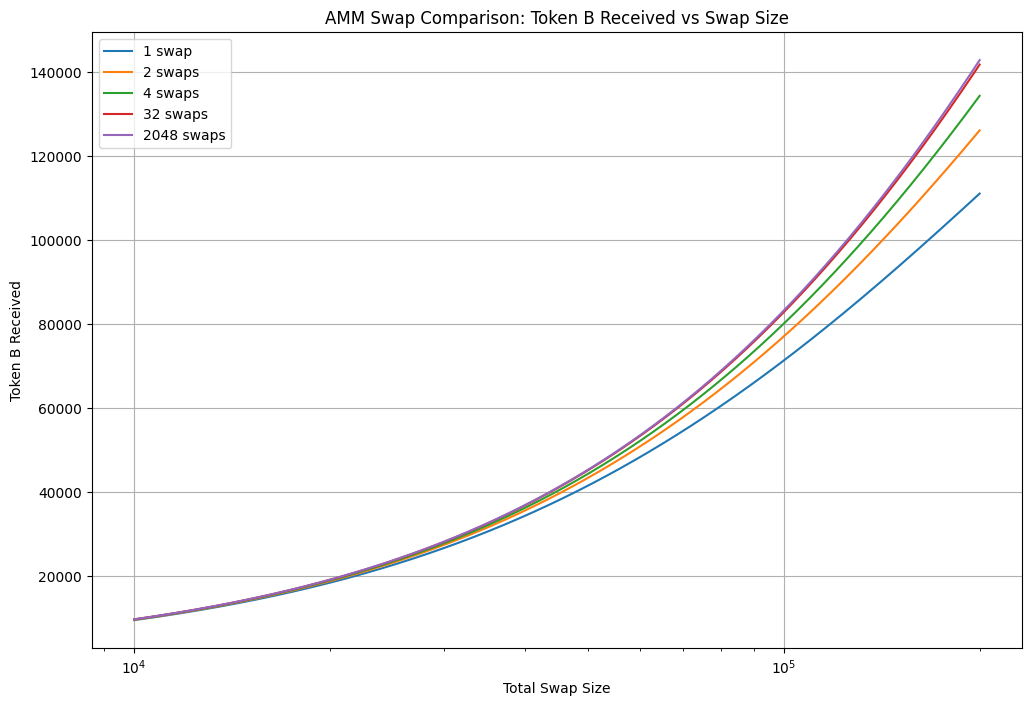

In [318]:
swap_sizes = np.logspace(np.log10(10000), np.log10(200000), num=10000)
scenarios = [1, 2, 4, 32,2048]
results = {s: {'token_out': [], 'fee': []} for s in scenarios}

for size in swap_sizes:
    for s in scenarios:
        swap_amounts = [size / s] * s  # Create the list of swap amounts for the given scenario
        token_out, fee, _ = run_scenario(f"Scenario {s} swaps: Total swap of {size:.2f} token A", swap_amounts)  # Correct unpacking
        results[s]['token_out'].append(token_out)  # Append token out for the current swap size
        results[s]['fee'].append(fee)  

# Create the plot for token out
plt.figure(figsize=(12, 8))

# Plot token out
for s in scenarios:
    plt.plot(swap_sizes, results[s]['token_out'], label=f'{s} swap{"s" if s > 1 else ""}')

plt.xscale('log')
plt.xlabel('Total Swap Size')
plt.ylabel('Token B Received')
plt.title('AMM Swap Comparison: Token B Received vs Swap Size')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

We observe that larger trades (close to the liquidity threshold) will definitely be split into many small trades. Smaller trades on the level of 5% of the liquidity will not necessarily be split, at most in 2 or three trades.

## A random trading series

This is partially unrealistic for the following reason: in the previous discussion we established that splitting trades is useful. In this discussion we assume that the trades are, against better judgement, done in one go. However, the trade size is small enough to warrant considering a single trade.

Results for AMM with fee multiplier 2:
{'LVR (excluding fees)': 1861.4514728756621, 'IL (excluding fees)': 173.45078936289065, 'total_fees': 4145.679896410305, 'LVR': -2284.2284235346433, 'IL': -3972.229107047415}

Results for AMM with fee multiplier 0:
{'LVR (excluding fees)': 1884.6767291817814, 'IL (excluding fees)': 176.6867511739256, 'total_fees': 388.47772953975044, 'LVR': 1496.198999642031, 'IL': -211.79097836582486}


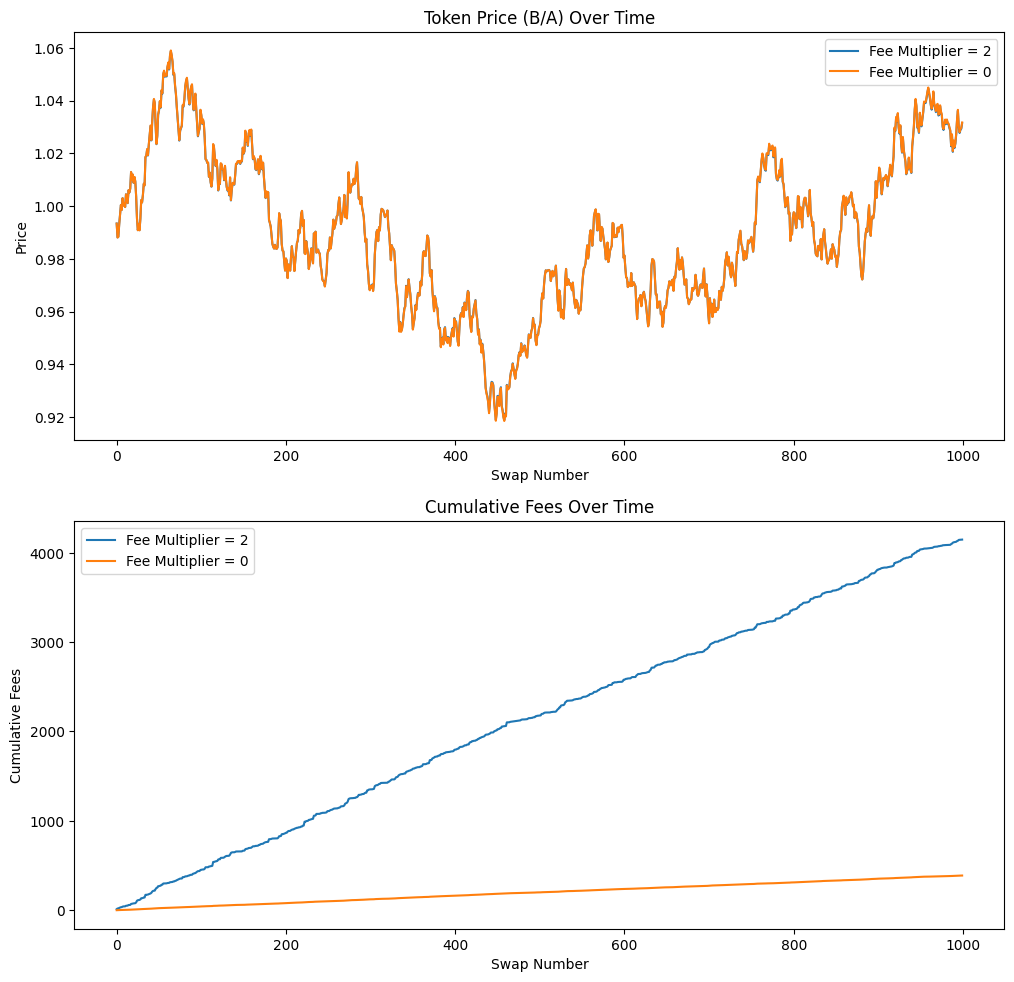

In [319]:
def generate_trade_series(num_swaps):
    return [(random.choice([True, False]), abs(random.gauss(100, 1000))) for _ in range(num_swaps)]

def run_simulation(amm, trade_series):
    prices = []
    fees = []
    lvrs = []
    volumes = []

    for is_token_a, token_in_amount in trade_series:
        _, fee_amount = amm.swap(token_in_amount, is_token_a)
        
        price = amm.get_price()
        tvl = amm.get_tvl()
        volume = sum(volumes) + token_in_amount
        
        prices.append(price)
        fees.append(fee_amount)
        lvrs.append(tvl / volume if volume > 0 else float('inf'))
        volumes.append(token_in_amount)

    return prices, fees, lvrs

def random_walk_analysis(price_list, fee_list, sigma0, L):
    def f(x):
        return L / math.sqrt(x)

    p0 = price_list[0]
    steps = len(price_list) - 1

    # Calculate accumulated value
    accumulated_value = 0
    for i in range(1, len(price_list)):
        x_prev = f(price_list[i-1])
        x_new = f(price_list[i])
        accumulated_value += x_prev * (1 + price_list[i-1] / price_list[i]) - 2 * x_new

    # Final price after the random walk
    final_price = price_list[-1]

    # Expression using start and final prices
    start_price_expression = f(price_list[0]) * (1 + price_list[0] / final_price) - 2 * f(final_price)

    # Total fees collected
    total_fees = sum(fee_list)

    return {
        "LVR (excluding fees)": accumulated_value,
        "IL (excluding fees)": start_price_expression,
        "total_fees": total_fees, "LVR": accumulated_value-total_fees, "IL":start_price_expression-total_fees
    }

# Run the simulations
num_swaps = 1000
initial_reserves = 500000
base_fee = 0.0005

# Generate a single trade series to be used for both AMM instances
trade_series = generate_trade_series(num_swaps)

amm1 = AMM(token_a_reserve=initial_reserves, token_b_reserve=initial_reserves, base_fee=base_fee, fee_multiplier=2)
amm2 = AMM(token_a_reserve=initial_reserves, token_b_reserve=initial_reserves, base_fee=base_fee, fee_multiplier=0)

prices1, fees1, lvrs1 = run_simulation(amm1, trade_series)
prices2, fees2, lvrs2 = run_simulation(amm2, trade_series)

# Perform random walk analysis
sigma0 = 0.01  # You may want to adjust this value
L = 500000  # You may want to adjust this value

results1 = random_walk_analysis(prices1, fees1, sigma0, L)
results2 = random_walk_analysis(prices2, fees2, sigma0, L)

print("Results for AMM with fee multiplier 2:")
print(results1)
print("\nResults for AMM with fee multiplier 0:")
print(results2)

# Plotting
plt.figure(figsize=(12, 18))

# Price comparison
plt.subplot(3, 1, 1)
plt.plot(prices1, label='Fee Multiplier = 2')
plt.plot(prices2, label='Fee Multiplier = 0')
plt.title('Token Price (B/A) Over Time')
plt.xlabel('Swap Number')
plt.ylabel('Price')
plt.legend()

# Cumulative fees comparison
plt.subplot(3, 1, 2)
plt.plot(np.cumsum(fees1), label='Fee Multiplier = 2')
plt.plot(np.cumsum(fees2), label='Fee Multiplier = 0')
plt.title('Cumulative Fees Over Time')
plt.xlabel('Swap Number')
plt.ylabel('Cumulative Fees')
plt.legend()


plt.show()

I can also average over many runs to get a better picture

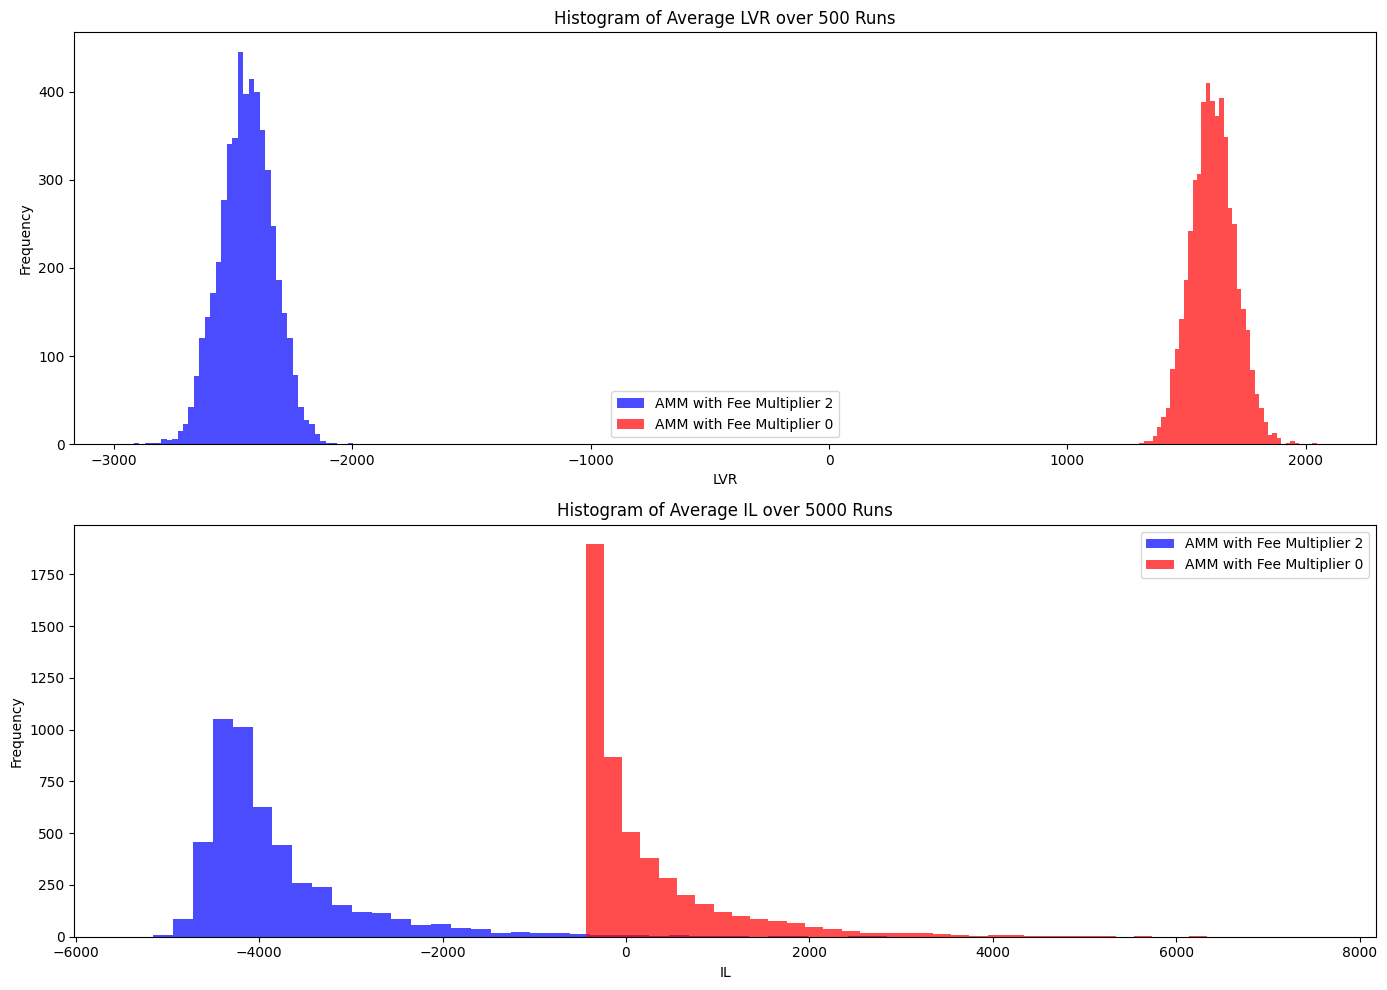

In [320]:
# Simulation settings
num_runs = 5000  # Run 500 simulations
results_avg_LVR_1 = []
results_avg_IL_1 = []
results_avg_LVR_2 = []
results_avg_IL_2 = []

for _ in range(num_runs):
    trade_series = generate_trade_series(num_swaps)

    # Create AMM instances with different fee multipliers
    amm1 = AMM(token_a_reserve=initial_reserves, token_b_reserve=initial_reserves, base_fee=base_fee, fee_multiplier=2)
    amm2 = AMM(token_a_reserve=initial_reserves, token_b_reserve=initial_reserves, base_fee=base_fee, fee_multiplier=0)

    # Run simulations
    prices1, fees1, lvrs1 = run_simulation(amm1, trade_series)
    prices2, fees2, lvrs2 = run_simulation(amm2, trade_series)

    # Perform random walk analysis
    results1 = random_walk_analysis(prices1, fees1, sigma0, L)
    results2 = random_walk_analysis(prices2, fees2, sigma0, L)

    # Collect average LVR and IL for each simulation
    results_avg_LVR_1.append(results1["LVR"])
    results_avg_IL_1.append(results1["IL"])
    results_avg_LVR_2.append(results2["LVR"])
    results_avg_IL_2.append(results2["IL"])

# Plotting the histograms for the LVR averages
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.hist(results_avg_LVR_1, bins=40, alpha=0.7, label='AMM with Fee Multiplier 2', color='blue')
plt.hist(results_avg_LVR_2, bins=40, alpha=0.7, label='AMM with Fee Multiplier 0', color='red')
plt.title('Histogram of Average LVR over 500 Runs')
plt.xlabel('LVR')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(results_avg_IL_1, bins=40, alpha=0.7, label='AMM with Fee Multiplier 2', color='blue')
plt.hist(results_avg_IL_2, bins=40, alpha=0.7, label='AMM with Fee Multiplier 0', color='red')
plt.title('Histogram of Average IL over 5000 Runs')
plt.xlabel('IL')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Taking a random series as a measuring stick, we find that the volume dependent fees seriously outperform the static fee setting. 

## Arbitrage

The idea is to simulate an infinite liquidity source/sink of tokens that carries an absolute price. We assume that the AMM is just reacting to the arbitrage and in a first step assume there is no random trading on top. 

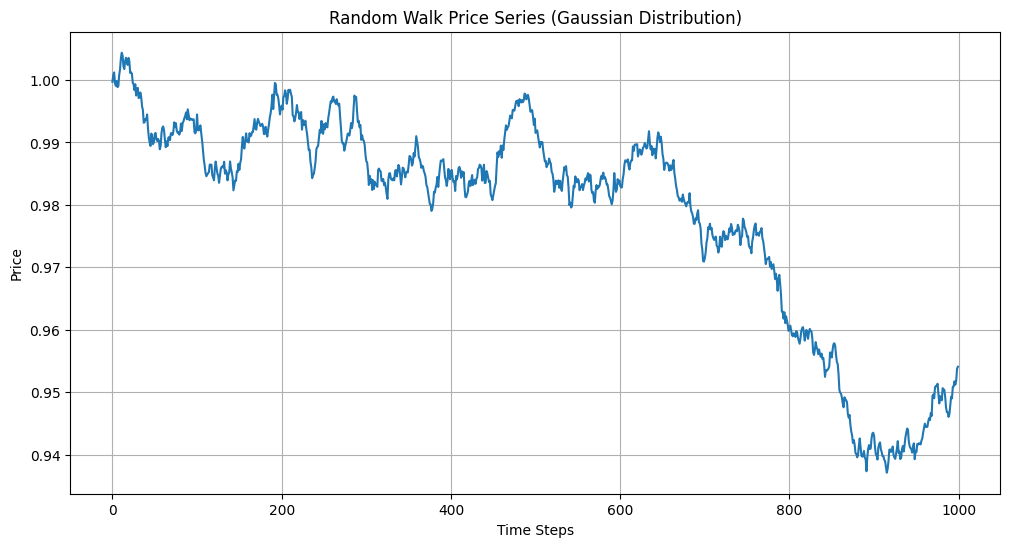

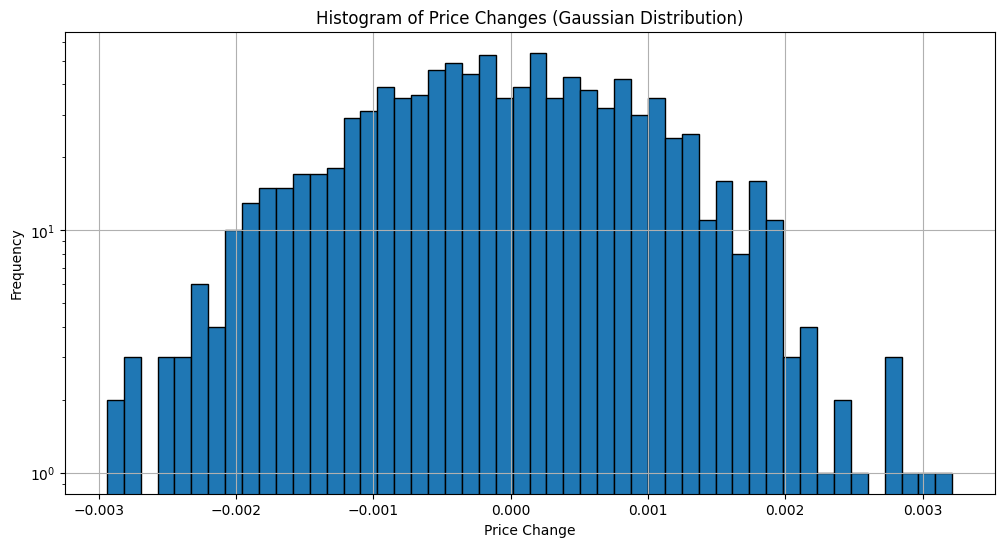

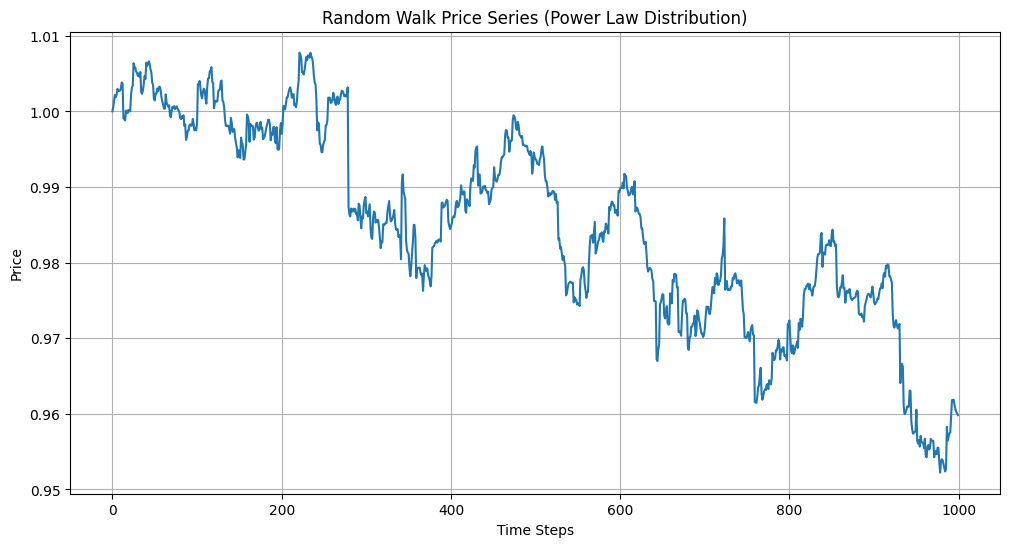

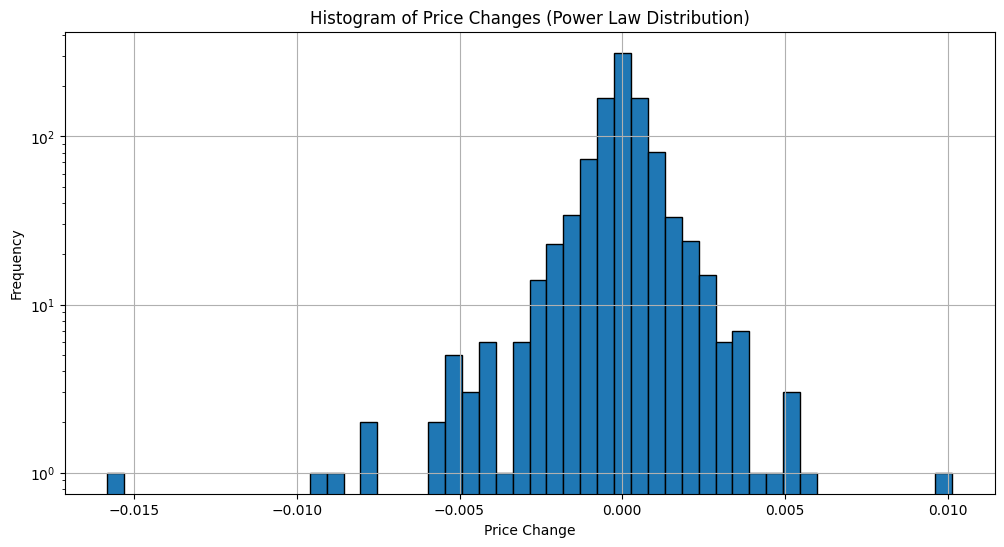

In [321]:
def generate_price_series(initial_price, num_steps, distribution='gaussian', **params):
    if distribution == 'gaussian':
        mu = params.get('mu', 0)
        sigma = params.get('sigma', 1)
        random_changes = np.random.normal(mu, sigma, num_steps)
    elif distribution == 'power_law':
        alpha = params.get('alpha', 3)
        x_min = params.get('x_min', 0.1)
        random_changes = np.random.pareto(alpha, num_steps) * x_min
        random_changes *= np.random.choice([-1, 1], num_steps)
    else:
        raise ValueError("Distribution must be either 'gaussian' or 'power_law'")
    
    cumulative_changes = np.cumsum(random_changes)
    price_series = initial_price + cumulative_changes
    
    return price_series

def plot_price_series(prices, title):
    plt.figure(figsize=(12, 6))
    plt.plot(prices)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

def plot_changes_histogram(prices, title):
    price_changes = np.diff(prices)
    plt.figure(figsize=(12, 6))
    plt.hist(price_changes, bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel('Price Change')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Example usage
initial_price = 1
num_steps = 1000

# Gaussian distribution
gaussian_prices = generate_price_series(initial_price, num_steps, 'gaussian', mu=0, sigma=0.001)
plot_price_series(gaussian_prices, 'Random Walk Price Series (Gaussian Distribution)')
plot_changes_histogram(gaussian_prices, 'Histogram of Price Changes (Gaussian Distribution)')

# Power law distribution
power_law_prices = generate_price_series(initial_price, num_steps, 'power_law', alpha=3, x_min=0.002)
plot_price_series(power_law_prices, 'Random Walk Price Series (Power Law Distribution)')
plot_changes_histogram(power_law_prices, 'Histogram of Price Changes (Power Law Distribution)')


We are working with a dynamical fee that grows with the volume according to $f(\Delta y)=f_0+f_1 \frac{\Delta y}{y_0}$ where $y_0$ is the amount of taken B in the AMM. For a price on the CEX $p_{CEX}(1-f_0)>p$, the optimal swap is the one that optimizes $G\approx y_0 \left( \frac{\alpha}{1+\frac{\Delta y}{y_0}\left(1-f(\Delta y)\right)}\left(1-f(\Delta y)\right)-1\right)\frac{\Delta y}{y_0}$ with $\alpha=\frac{p_{CEX}}{p}$ (established above that one can do better by splitting the swap into smaller swaps). For now we assume that the arbitrageur makes a series of optimal swaps, for now just one. We are looking for the optimal swap $\delta=\Delta y/y_0 \ll 1$ with $f_0 \ll 1$ and $f_1=\mathcal{O}(1)$ which allows us to expand the expression to lowest order in $f_0$ and $\delta$. In this limit, the optimal swap allowing to gain most with one swap consists of $\Delta y^{opt} \approx y_0\frac{\alpha(1-f_0)-1}{2\alpha(1-2f_0+f_1)}$. In the case of $p_{CEX}/(1-f_0)<p$ one has to trade $y\to x$ and $\alpha \to 1/\alpha$. 

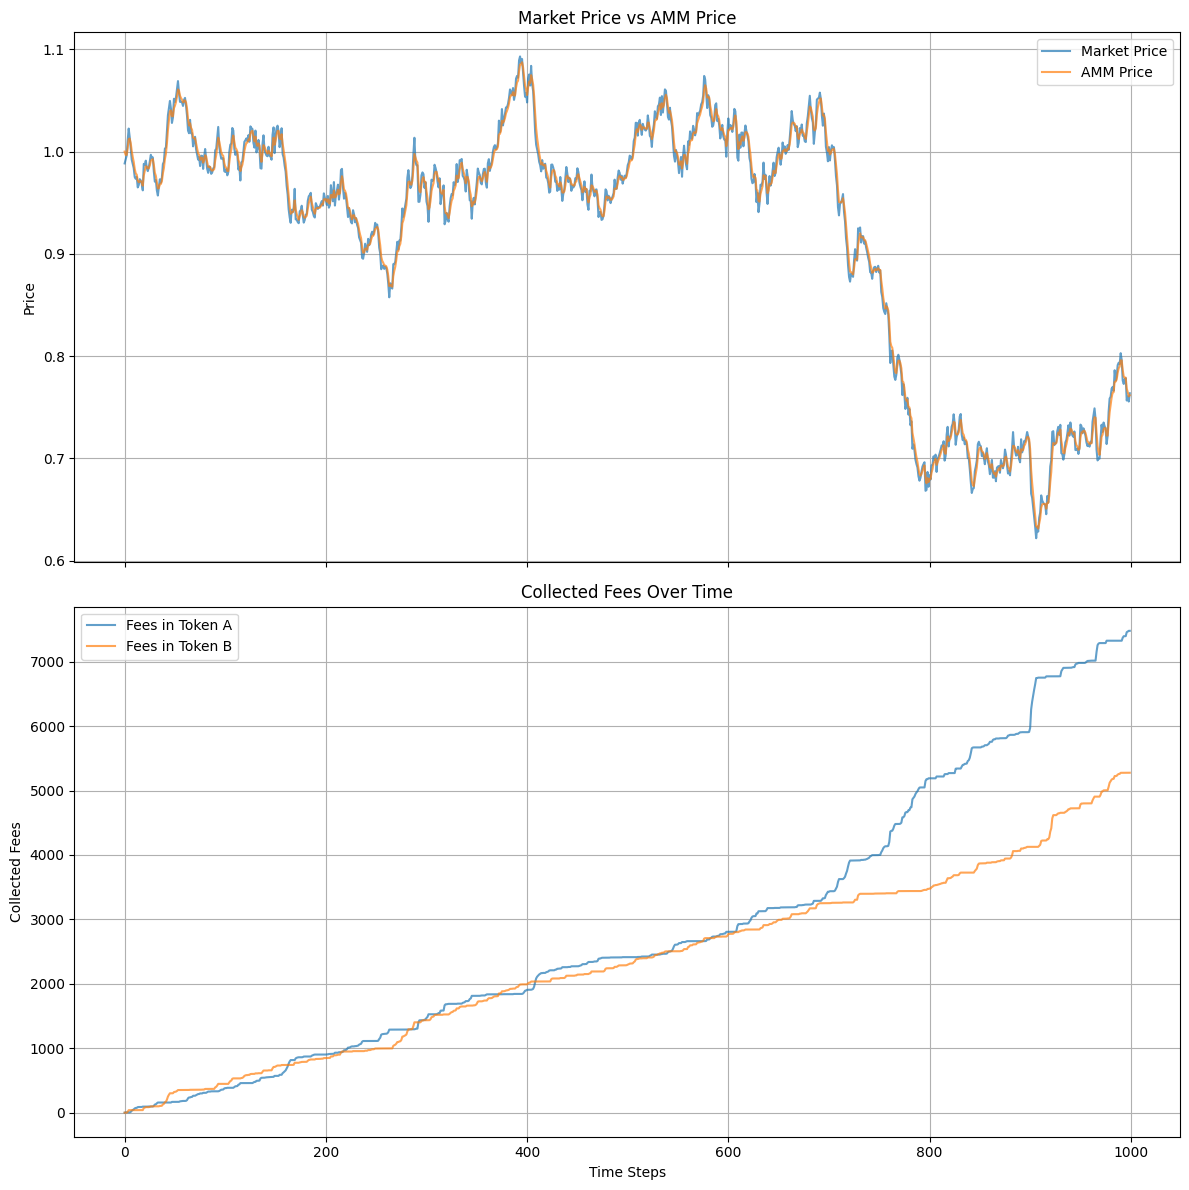

Final AMM price: 0.76
Final market price: 0.76
Total fees collected in Token A: 7479.29
Total fees collected in Token B: 5276.29
Final TVL: 2018554.72


In [325]:
def simulate_arbitrage(amm, price_series, base_fee):
    amm_prices = [amm.get_price()]
    fees_a = [0]
    fees_b = [0]

    for price in price_series[1:]:
        amm_price = amm.get_price()

        if price * (1 - base_fee) > amm_price:
            # Arbitrage opportunity: swap token B for token A
            swap_amount = amm.token_b_reserve * (price / amm_price * (1 - base_fee) - 1) / (2 * price / amm_price * (1 - 2 * base_fee + amm.fee_multiplier))
            token_out, fee = amm.swap(swap_amount, is_token_a=False)
        elif price / (1 - base_fee) < amm_price:
            # Arbitrage opportunity: swap token A for token B
            swap_amount = amm.token_a_reserve * (amm_price / price * (1 - base_fee) - 1) / (2 * amm_price / price * (1 - 2 * base_fee + amm.fee_multiplier))
            token_out, fee = amm.swap(swap_amount, is_token_a=True)

        amm_prices.append(amm.get_price())
        fees_a.append(amm.collected_fees_a)
        fees_b.append(amm.collected_fees_b)

    return amm_prices, fees_a, fees_b

# Simulation parameters
initial_price = 1
num_steps = 1000
token_a_reserve = 1000000
token_b_reserve = initial_price * token_a_reserve
base_fee = 0.001
fee_multiplier = 1.

# Generate price series
price_series = generate_price_series(initial_price, num_steps, 'gaussian', mu=0, sigma=0.01)

# Initialize AMM
amm = AMM(token_a_reserve, token_b_reserve, base_fee, fee_multiplier)

# Simulate arbitrage
amm_prices, fees_a, fees_b = simulate_arbitrage(amm, price_series, base_fee)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Price series and AMM price plot
ax1.plot(price_series, label='Market Price', alpha=0.7)
ax1.plot(amm_prices, label='AMM Price', alpha=0.7)
ax1.set_ylabel('Price')
ax1.set_title('Market Price vs AMM Price')
ax1.legend()
ax1.grid(True)

# Collected fees plot
ax2.plot(fees_a, label='Fees in Token A', alpha=0.7)
ax2.plot(fees_b, label='Fees in Token B', alpha=0.7)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Collected Fees')
ax2.set_title('Collected Fees Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"Final AMM price: {amm_prices[-1]:.2f}")
print(f"Final market price: {price_series[-1]:.2f}")
print(f"Total fees collected in Token A: {fees_a[-1]:.2f}")
print(f"Total fees collected in Token B: {fees_b[-1]:.2f}")
print(f"Final TVL: {amm.get_tvl():.2f}")

In [326]:
results = random_walk_analysis(price_series, fees_a, 0, 1000000)

In [327]:
print(results)

{'LVR (excluding fees)': 36399.05978939147, 'IL (excluding fees)': 19079.59679682413, 'total_fees': 2847914.224667535, 'LVR': -2811515.164878144, 'IL': -2828834.627870711}
